<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Добавление-признаков" data-toc-modified-id="Добавление-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Добавление признаков</a></span></li><li><span><a href="#Тренировка-моделей" data-toc-modified-id="Тренировка-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тренировка моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>RandomForest</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

## Подготовка

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('taxi.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков нет, это хорошо.

In [5]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Переведем дату во временной формат

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [7]:
data['datetime'].is_monotonic

True

Сортировать не нужно, время идет как полагается

In [8]:
data = data.set_index('datetime')

Сделаем ресэмплирование по одному часу

In [9]:
data = data.resample('1H').sum()

## Анализ

Сначала просто посмотрим на данные, возьмем промежутки в час, день и три дня. Будем строить чистые данные и скользящее среднее

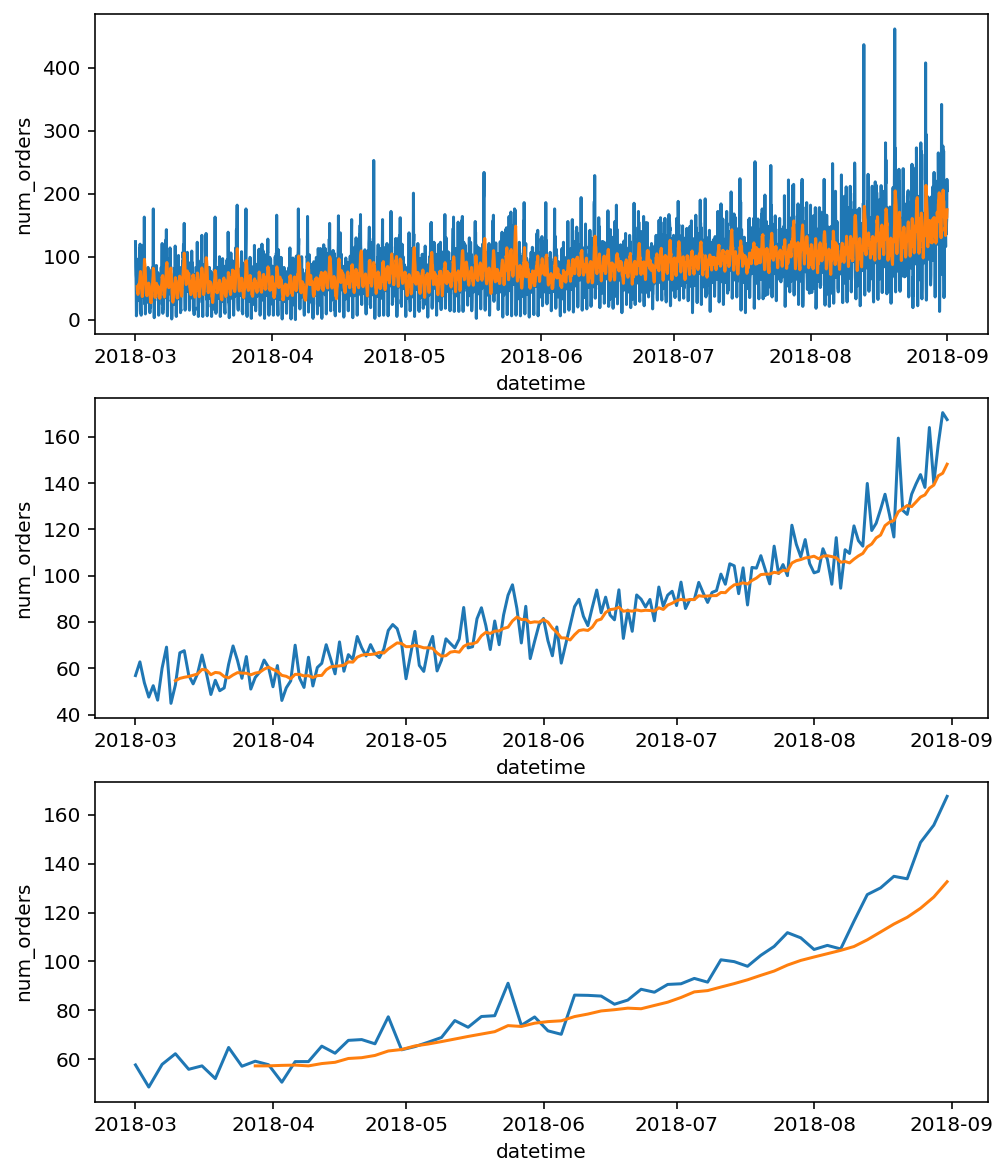

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
for (t, ax) in zip(['1H', '1D', '3D'], axes):
    tmp = data.resample(t).mean()
    sns.lineplot(ax=ax, data=tmp, x='datetime', y='num_orders')
    sns.lineplot(ax=ax, data=tmp.rolling(10).mean(), x='datetime', y='num_orders')


Какой-то периодичности тут не видно, скорее число заказов практически монотонно возрастает. Попробуем посчитать тренд и сезонность

In [11]:
decompose = seasonal_decompose(data)

<AxesSubplot:title={'center':'Тренд'}, xlabel='datetime'>

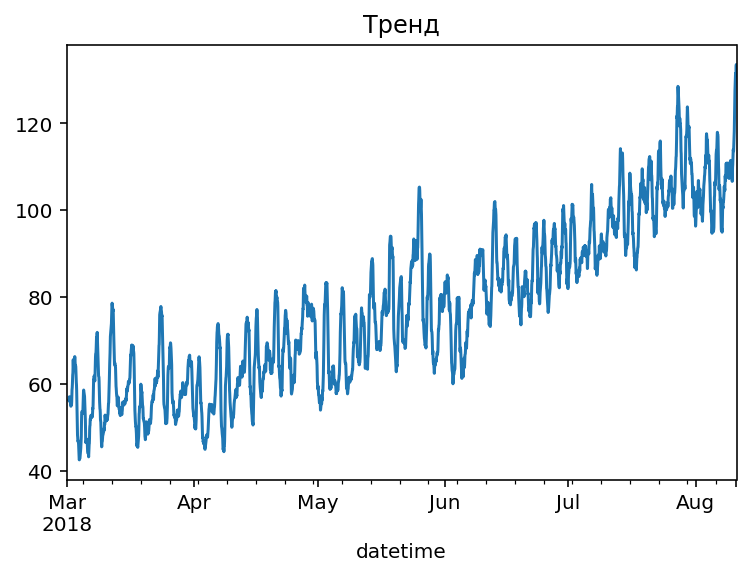

In [12]:
plt.figure()
plt.title('Тренд')
decompose.trend['2018-03-01':'2018-08-10'].plot(ax=plt.gca())

<AxesSubplot:title={'center':'Сезонность'}, xlabel='datetime'>

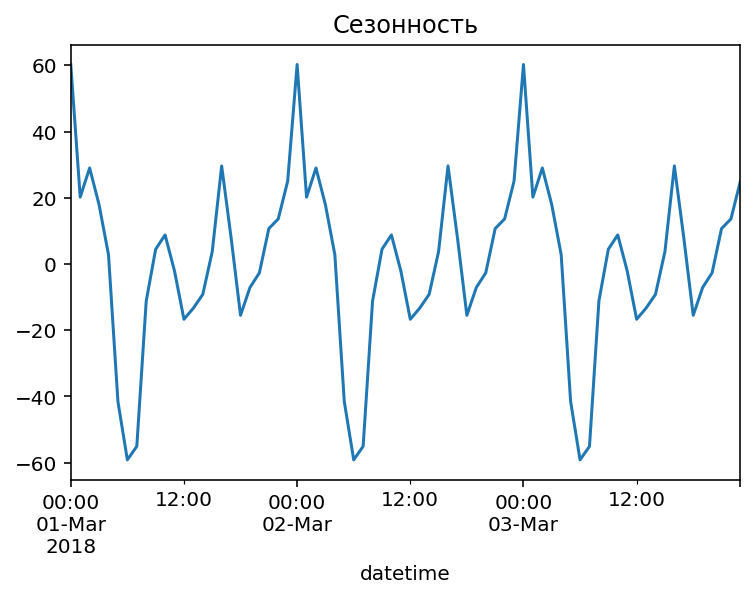

In [13]:
plt.figure()
plt.title('Сезонность')
decompose.seasonal['2018-03-01':'2018-03-3'].plot(ax=plt.gca())

Если из общей зависимости монотонное увеличение еще можно было разглядеть, но вот отследить сезонность сомнительно. Во всяком случае здесь она есть, она не меняется на большом промежутке времени, то есть стационарная. Это выглядит логично, потому как расписание рейсов в аэропортах навряд ли меняется часто.

ps: тут на самом деле я не нашел формулу, по которой считается, поэтому как-то не особо это все понятно, как вытягиваются эти зависимости. Всмысле понятно, что значит, но не понятно как считается


## Обучение

### Добавление признаков

Здесь сделаем такую же вещь как в тренажере - создадим функцию по генерации новых признаков и проварьируем результат линейной регрессии от числа добавленных признаков. При добавлении новых признаков в виде скользящего  среднего и отстающих значений будут возникать пробелы я буду убирать их тренировочных данных

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy(deep=True)
    data['hour'] = data.index.hour
    data['day_of_the_week'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    return data

Зададим функцию потерь и закрепим генератор псевдослучайных чисел

In [15]:
seed = 4

In [16]:
rmse = lambda y_true, predicted: mean_squared_error(y_true, predicted)**0.5

### Тренировка моделей


Я хочу делать кросс-валидацию, но обычную тут не получится применить, так как там блоки обучения и теста переставляются и получится, что я тренировал модель на данных из будующего, а предсказывал данные из прошлого. Вот [тут](https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sci) нашел как вставляется TimeSeriesSplit в поиск по решетке

In [17]:
time_cv = TimeSeriesSplit(n_splits=4)

#### Линейная регрессия

In [18]:
pipe = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
        ('lr', Ridge())
    ]
)

grid = GridSearchCV(
    estimator=pipe,
    param_grid={
        'lr__alpha': [1e-04, 1e-03, 0.01] + list(np.arange(0.1, 1.01, 0.1))
    },
    cv=time_cv,
    scoring=make_scorer(rmse, greater_is_better=False) 
)

In [19]:
rest_data, test_data = train_test_split(data, shuffle=False, test_size=0.1)

In [20]:
%%time
lags = [1, 5, 10, 20, 50, 100, 150, 160, 180, 190, 220]
scores = []
best_lr_score = None
for lag in lags:
    df = make_features(rest_data, lag, 5)
    train, valid = train_test_split(df, test_size=0.1, shuffle=False)
    features = train.drop('num_orders', axis=1)
    target = train['num_orders']
    grid.fit(features, target)
    if best_lr_score is None or -grid.best_score_ < best_lr_score:
        best_lr_score = -grid.best_score_
        best_lr_model = grid.best_estimator_
    scores.append(-grid.best_score_)

CPU times: user 32.9 s, sys: 1min 14s, total: 1min 47s
Wall time: 1min 47s


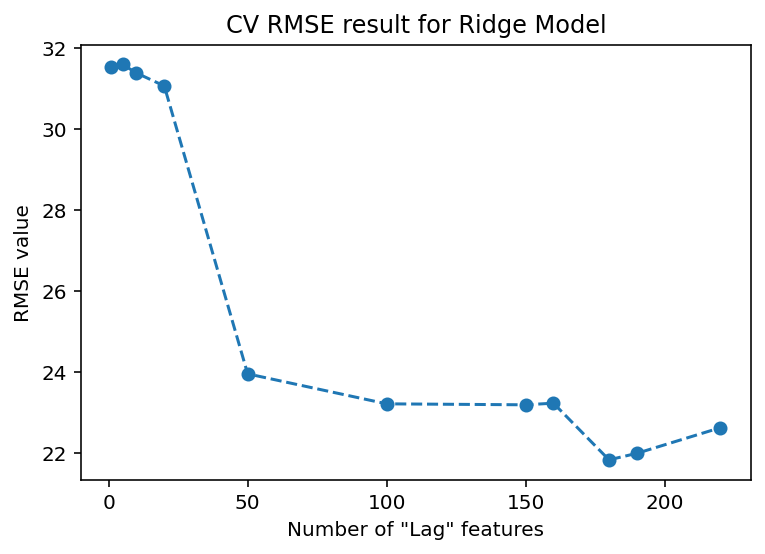

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(lags, scores, '--o')
ax.set(
    title='CV RMSE result for Ridge Model',
    xlabel='Number of "Lag" features',
    ylabel='RMSE value'
);

Выходит, что добавлять признаки LAG (отстающие) для модели Риджа имеет смысл до 180. Далее RMSE начинает давать результаты хуже

In [22]:
train, valid = train_test_split(make_features(rest_data, 180, 5), test_size=0.1, shuffle=False)

In [23]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

In [24]:
predict = best_lr_model.predict(features_valid)
rmse(target_valid, predict)

28.121412991133575

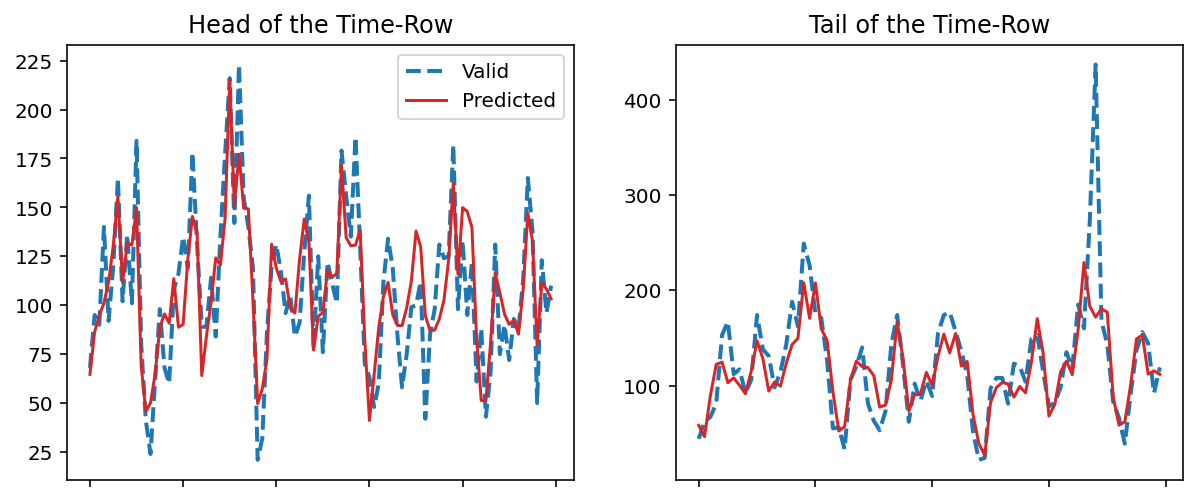

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

index = np.arange(100)
ax[0].plot(target_valid.values[index], color='tab:blue', lw=2, ls='--', label='Valid')
ax[0].plot(predict[index], color='tab:red', label='Predicted')
ax[0].set_xticklabels([])
ax[0].set_title('Head of the Time-Row')
ax[0].legend()

index = np.arange(300, 380)
ax[1].plot(target_valid.values[index], color='tab:blue', lw=2, ls='--', label='Valid')
ax[1].plot(predict[index], color='tab:red', label='Predicted')
ax[1].set_xticklabels([])
ax[1].set_title('Tail of the Time-Row');

#### LightGBM

In [26]:
lgbm_model = lgb.LGBMRegressor(
    random_state=seed, 
    metric='rmse'
)

pipe = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
        ('lgbm_boosting', lgbm_model)
    ]
)

In [27]:
grid_lgbm = GridSearchCV(
    estimator=pipe, 
    param_grid={
        'lgbm_boosting__learning_rate': [1e-04, 1e-03, 1e-2, 0.1],
        'lgbm_boosting__n_estimators': [100]
    },
    cv=time_cv,
    n_jobs=-1,
    scoring=make_scorer(rmse, greater_is_better=False)   
)

Я очень не люблю пускать поиск гиперпараметров на платформе, так как считается там это все безумно долго, но по заданию это нужно, поэтому я сокращу число новых признаков для градиентного бустинга и модели случайного леса. Результаты не будут максимальными из того, что можно выжать из этих моделей, но установленный порог пройдут

In [28]:
train, valid = train_test_split(make_features(rest_data, 10, 5), test_size=0.1, shuffle=False)

In [29]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

In [30]:
%%time
grid_lgbm.fit(features_train, target_train)

CPU times: user 15min 53s, sys: 19.5 s, total: 16min 12s
Wall time: 16min 19s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('lgbm_boosting',
                                        LGBMRegressor(metric='rmse',
                                                      random_state=4))]),
             n_jobs=-1,
             param_grid={'lgbm_boosting__learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1],
                         'lgbm_boosting__n_estimators': [100]},
             scoring=make_scorer(<lambda>, greater_is_better=False))

In [31]:
best_lgbm_model = grid_lgbm.best_estimator_
predict = best_lgbm_model.predict(features_valid)

In [32]:
rmse(target_valid, predict)

32.16088253378498

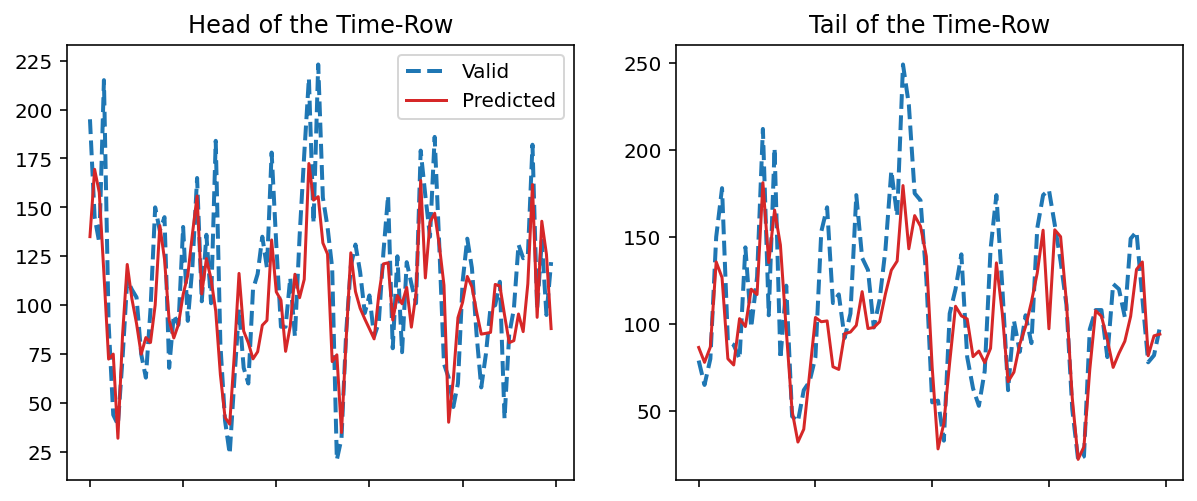

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

index = np.arange(100)
ax[0].plot(target_valid.values[index], color='tab:blue', lw=2, ls='--', label='Valid')
ax[0].plot(predict[index], color='tab:red', label='Predicted')
ax[0].set_xticklabels([])
ax[0].set_title('Head of the Time-Row')
ax[0].legend()

index = np.arange(300, 380)
ax[1].plot(target_valid.values[index], color='tab:blue', lw=2, ls='--', label='Valid')
ax[1].plot(predict[index], color='tab:red', label='Predicted')
ax[1].set_xticklabels([])
ax[1].set_title('Tail of the Time-Row');

Значение метрики rmse получилось хуже, нежели для линейной регрессии

#### RandomForest

In [34]:
rf_model = RandomForestRegressor(random_state=seed)
grid_rf = GridSearchCV(
    estimator=rf_model, 
    param_grid={
        'n_estimators': [64],
        'max_depth': [1, 2, 4, 8, 16]
    },
    cv=time_cv,
    n_jobs=-1,
    scoring=make_scorer(rmse, greater_is_better=False)   
)

In [35]:
%%time
grid_rf.fit(features_train, target_train)

CPU times: user 7.43 s, sys: 28.6 ms, total: 7.46 s
Wall time: 7.47 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=RandomForestRegressor(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 8, 16], 'n_estimators': [64]},
             scoring=make_scorer(<lambda>, greater_is_better=False))

In [36]:
best_rf_model = grid_rf.best_estimator_

In [37]:
predict = grid_rf.predict(features_valid)

In [38]:
rmse(target_valid, predict)

33.8902808213903

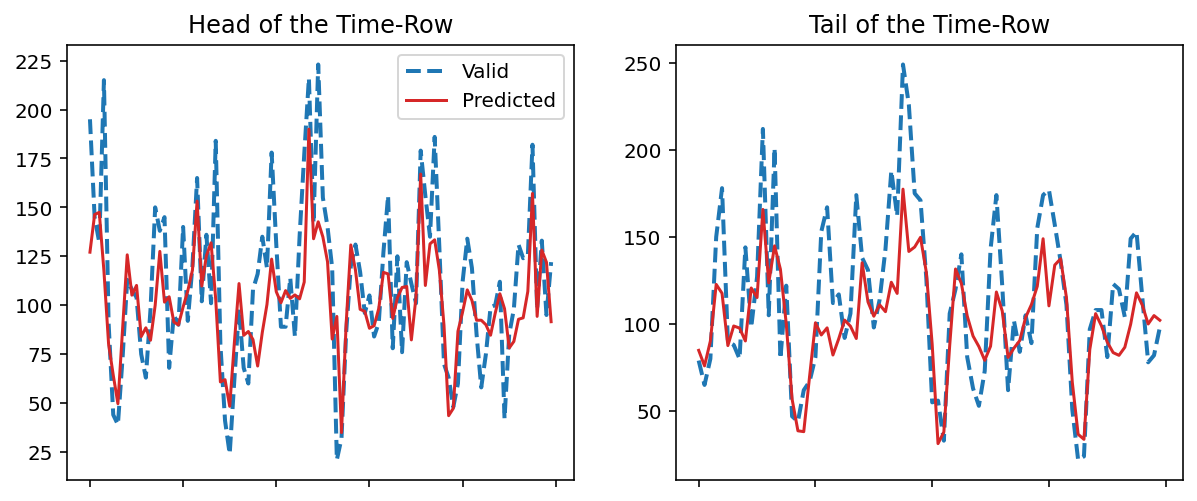

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

index = np.arange(100)
ax[0].plot(target_valid.values[index], color='tab:blue', lw=2, ls='--', label='Valid')
ax[0].plot(predict[index], color='tab:red', label='Predicted')
ax[0].set_xticklabels([])
ax[0].set_title('Head of the Time-Row')
ax[0].legend()

index = np.arange(300, 380)
ax[1].plot(target_valid.values[index], color='tab:blue', lw=2, ls='--', label='Valid')
ax[1].plot(predict[index], color='tab:red', label='Predicted')
ax[1].set_xticklabels([])
ax[1].set_title('Tail of the Time-Row');

После подборки гиперпараметров и тестирования трех моделей мы имеем следующий результат на валидационной выборке 

|Ridge|LightGBM|RF|
|-|-|-|
|28.1|32.2|33.9||

Таким образом, по результатам кросс-валидации лучшей моделью оказалась линейная модель.

## Тестирование

Теперь посмотрим на результат на тестовой выборке, но сначала дообучим модель на тренировочных и валидационных данных

In [40]:
train = make_features(rest_data, 180, 5)
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

In [41]:
best_lr_model.fit(features_train, target_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('lr', Ridge())])

Делаем тестовые данные

In [42]:
test = make_features(test_data, 180, 5)
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [43]:
lr_test_predict = best_lr_model.predict(features_test)
lr_test_result = rmse(target_test, lr_test_predict)

In [44]:
print(f"RMSE Test Score: {lr_test_result:.3f}")

RMSE Test Score: 35.286


Порог мы проскочили, но как я уже отмечал, из этих моделей можно выжать результат получше. Просто считать долго)

Сравним с "константными" моделями

In [45]:
print(f"RMSE Mean Score: {rmse(target_test, np.ones(target_test.shape[0])*target_test.mean())}")

RMSE Mean Score: 59.11647723978782


In [46]:
pred_previous = target_test.shift(fill_value=target_test.iloc[-1])
print(f"RMSE Mean Score: {rmse(target_test, pred_previous)}")

RMSE Mean Score: 60.05353845458259


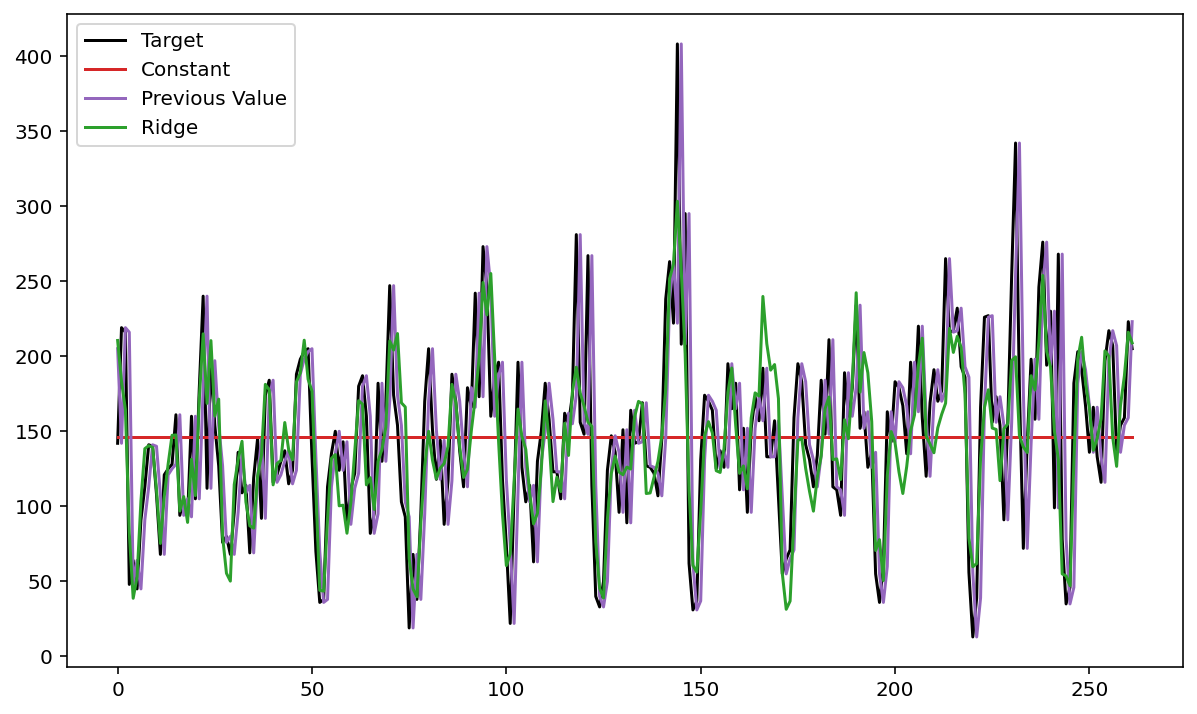

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(target_test.values, label='Target', color='k')
plt.plot(target_test.mean()*np.ones(target_test.shape[0]), label='Constant', color='tab:red')
plt.plot(pred_previous.values, label='Previous Value', color='tab:purple')
plt.plot(lr_test_predict, label='Ridge', color='tab:green')
plt.legend()

Последнее, что хочется сделать, это посмотреть получается ли воспроизводить модель Ridge тренд и сезонность

In [48]:
predict = best_lr_model.predict(features_test)

In [49]:
pr_df = pd.DataFrame(data=predict, index=target_test.index)

pr_decomposed = seasonal_decompose(pr_df)
ts_decomposed = seasonal_decompose(target_test)

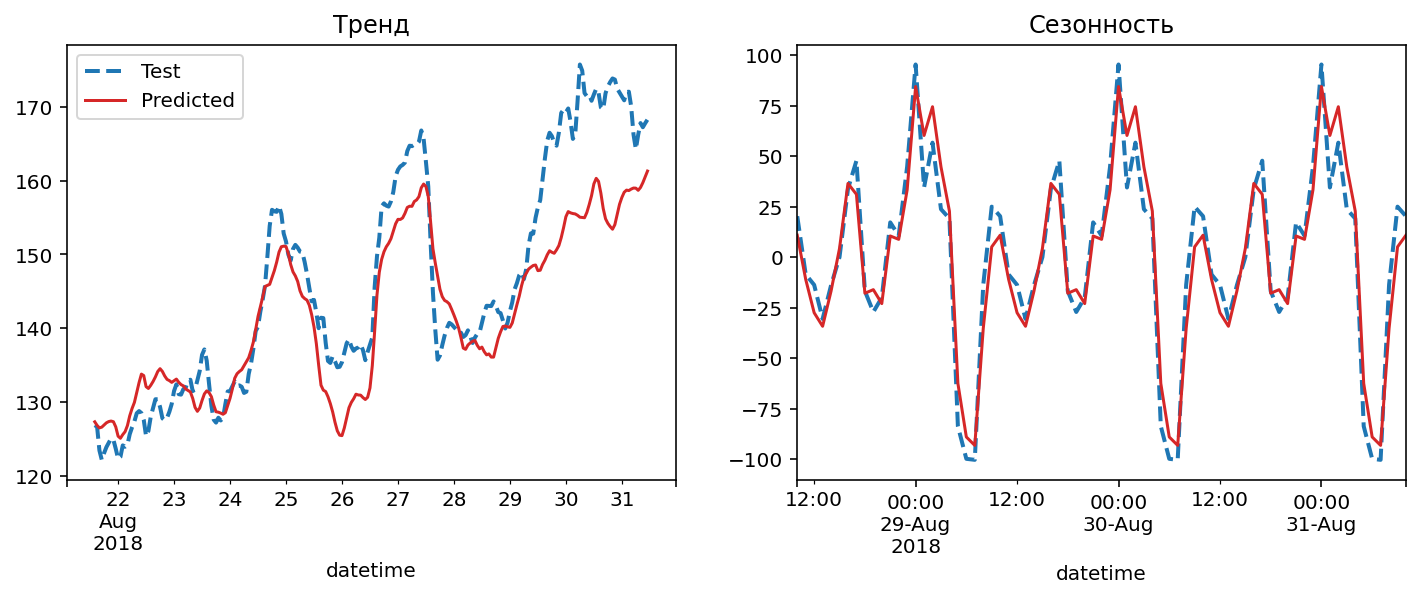

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('Тренд')
ts_decomposed.trend['2018-08-14 10:00:00':'2018-08-31 23:00:00'].plot(ax=ax[0], color='tab:blue', lw=2, ls='--', label='Test')
pr_decomposed.trend['2018-08-14 10:00:00':'2018-08-31 23:00:00'].plot(ax=ax[0], color='tab:red', label='Predicted')
ax[0].legend()

ax[1].set_title('Сезонность')
ts_decomposed.seasonal['2018-08-28 10:00:00':'2018-08-31 10:00:00'].plot(ax=ax[1], color='tab:blue', lw=2, ls='--', label='Test')
pr_decomposed.seasonal['2018-08-28 10:00:00':'2018-08-31 10:00:00'].plot(ax=ax[1], color='tab:red', label='Predicted');

Наша модель в целом повторяет форму тренда. Самые пиковые точки наша модель, к сожалению, все еще не улавливает. Сезонность хорошо описывается выбранной моделью, периодичность осталась небольшие промахи есть только в пиковых точках.

## Вывод

В данном проекте по данным компании «Чётенькое такси» о заказах такси в аэропортах прогнозировалось почасовое количество заказов для привлечения в пиковый период большего количества водителей.

Данные представлены с марта 2018 по август 2018 включительно с десятиминутной задержкой. Исходные данные были пересэмплированы с протяженностью до 1 часа, чтобы отвечать выставленным требованиям. Также были добавлены новые признаки: календарные признаки, несколько отстающих значений и скользящее среднее.

Лучшая модель подбиралась на кросс-валидации по RMSE метрике. Среди кандидатов были линейная регрессия с регуляризацией, модель случайного леса и модель градиентного бустинга (LightGBM). Лучшей оказалась модель линейной регрессии Ridge (L2 регуляризатор), которая и предлагается заказчику для прогнозирования числа заказов. 